# DATA2001 : Assignment

**Author:** Lab10 - Group 08

## Importing Libraries


In [50]:
## Importing required libraries
import os
import numpy as np
import seaborn as sns
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json

## Creating SQL Connection

In [2]:
## Connecting to postgreSQL server (pgAdmin)
def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        notE = "This result object does not return rows. It has been closed automatically."
        if str(e) != notE: print(e)
    return result

In [3]:
## Converting polygon objects to multipolygon objects
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    elif geom.geom_type == 'Point':
        geom = Point([xy[0:2] for xy in list(geom.coords)])
    return WKTElement(geom.wkt, srid)


In [4]:
credentials = "Credentials.json"
currentDir = os.path.dirname("DATA2001Assignment")
db, conn = pgconnect(credentials)

Connected successfully.


## Reading and Cleaning Data


### SA2 Boundaries


In [5]:
# Reading the file from the provided location
SA2DigitalBoundariesPath = os.path.join(currentDir, "Data", "SA2 Digital Boundaries", "SA2_2021_AUST_GDA2020.shp")
SA2DigitalBoundaries = gpd.read_file(SA2DigitalBoundariesPath)

# Drop rows with null geometry and filter for Greater Sydney
SA2DigitalBoundaries.dropna(subset=['geometry'], inplace=True)
SA2DigitalBoundaries = SA2DigitalBoundaries[SA2DigitalBoundaries['GCC_NAME21'] == 'Greater Sydney'].copy()

# Convert geometry to WKT format and drop original geometry column
SA2DigitalBoundaries['geom'] = SA2DigitalBoundaries['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))
SA2DigitalBoundaries = SA2DigitalBoundaries.drop(columns="geometry")

# Drop unnecessary columns and remove duplicates
SA2DigitalBoundaries.drop(columns=['LOCI_URI21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21', 'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', "GCC_CODE21", "GCC_NAME21", "STE_CODE21", "STE_NAME21", "AUS_CODE21", "AUS_NAME21"], inplace=True)
SA2DigitalBoundaries.drop_duplicates(inplace=True)
SA2DigitalBoundaries.dropna(inplace=True)

# Rename columns to match the database schema
SA2DigitalBoundaries.rename(columns={"SA2_CODE21": "sa2_code21", "SA2_NAME21": "sa2_name21"}, inplace=True)

# Define and execute schema creation for SA2 table
schema = """
DROP TABLE IF EXISTS SA2;
CREATE TABLE SA2 (
    "sa2_code21" INTEGER,
    "sa2_name21" VARCHAR(255),
    "AREASQKM21" FLOAT,
    "geom" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)

# Insert data into the SA2 table
try:
    SA2DigitalBoundaries.to_sql("sa2", conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})
except Exception as e:
    print("Error inserting data:", e)
print(SA2DigitalBoundaries.info())
print()
print(query(conn, "select * from SA2 LIMIT 5"))


<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 28 to 641
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sa2_code21  373 non-null    object 
 1   sa2_name21  373 non-null    object 
 2   AREASQKM21  373 non-null    float64
 3   geom        373 non-null    object 
dtypes: float64(1), object(3)
memory usage: 14.6+ KB
None

   sa2_code21                   sa2_name21  AREASQKM21  \
0   102011028     Avoca Beach - Copacabana      6.4376   
1   102011029  Box Head - MacMasters Beach     32.0802   
2   102011030              Calga - Kulnura    767.9512   
3   102011031          Erina - Green Point     33.7934   
4   102011032        Gosford - Springfield     16.9123   

                                                geom  
0  0106000020E6100000010000000103000000010000005E...  
1  0106000020E61000000100000001030000000100000010...  
2  0106000020E61000000200000001030000000100000085...  
3  0106000020E610000001000

### School

In [6]:

# Read primary catchments shapefile
CatchmentPrimaryPath = os.path.join(currentDir, "Data", "catchments", "catchments_primary.shp")
CatchmentPrimary = gpd.read_file(CatchmentPrimaryPath)

# Convert geometry to WKT and drop original geometry column
CatchmentPrimary['Geometry'] = CatchmentPrimary['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))
CatchmentPrimary = CatchmentPrimary.drop(columns="geometry")

# Read secondary catchments shapefile
CatchmentSecondaryPath = os.path.join(currentDir, "Data", "catchments", "catchments_secondary.shp")
CatchmentSecondary = gpd.read_file(CatchmentSecondaryPath)

# Convert geometry to WKT and drop original geometry column
CatchmentSecondary['Geometry'] = CatchmentSecondary['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))
CatchmentSecondary = CatchmentSecondary.drop(columns="geometry")

# Concatenate primary and secondary catchments
school = pd.concat([CatchmentPrimary, CatchmentSecondary])

# Drop duplicates and unnecessary columns
school.drop_duplicates(inplace=True)
school.drop(columns=['ADD_DATE', 'KINDERGART', 'YEAR1', 'YEAR2', 'YEAR3', 'YEAR4', 'YEAR5', 'YEAR6', 'YEAR7', 'YEAR8', 'YEAR9', 'YEAR10', 'YEAR11', 'YEAR12', 'PRIORITY'], inplace=True)
school.dropna(inplace=True)

# Define schema for School table
schema = """
DROP TABLE IF EXISTS School;
CREATE TABLE School (
    "USE_ID" INTEGER,
    "CATCH_TYPE" VARCHAR(255),
    "USE_DESC" VARCHAR(255),
    "Geometry" GEOMETRY(MULTIPOLYGON, 4326)
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)

# Insert data into the School table
try:
    school.to_sql("school", conn, if_exists='append', index=False, dtype={'Geometry': Geometry('MULTIPOLYGON', 4326)})
except Exception as e:
    print("Error inserting data:", e)

# Verify data insertion by querying the School table
print(school.info())
print()
print(query(conn, "select * from school LIMIT 5"))


<class 'pandas.core.frame.DataFrame'>
Index: 2098 entries, 0 to 435
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   USE_ID      2098 non-null   object
 1   CATCH_TYPE  2098 non-null   object
 2   USE_DESC    2098 non-null   object
 3   Geometry    2098 non-null   object
dtypes: object(4)
memory usage: 82.0+ KB
None

   USE_ID CATCH_TYPE         USE_DESC  \
0    2838    PRIMARY       Parklea PS   
1    2404    PRIMARY    Lindfield EPS   
2    4393    PRIMARY  Carlingford WPS   
3    4481    PRIMARY    St Andrews PS   
4    4615    PRIMARY   Caddies Ck  PS   

                                            Geometry  
0  0106000020E61000000100000001030000000100000078...  
1  0106000020E610000001000000010300000001000000BE...  
2  0106000020E61000000100000001030000000100000065...  
3  0106000020E61000000100000001030000000100000040...  
4  0106000020E61000000100000001030000000100000056...  


### Business

In [7]:
# Path to the Businesses CSV file
BusinessPath = os.path.join(currentDir, "Data", "Businesses.csv")
# Read the CSV file
Business = pd.read_csv(BusinessPath)
# Drop unnecessary columns
Business.drop(columns=['industry_code'], inplace=True)
# Remove duplicates and rows with any null values
Business.drop_duplicates(inplace=True)
Business.dropna(inplace=True)
# Define schema for Business table
schema = """
DROP TABLE IF EXISTS Business;
CREATE TABLE Business (
    "industry_name" VARCHAR(255),
    "sa2_code" INTEGER,
    "sa2_name" VARCHAR(255),
    "0_to_50k_businesses" INTEGER,
    "50k_to_200k_businesses" INTEGER,
    "200k_to_2m_businesses" INTEGER,
    "2m_to_5m_businesses" INTEGER,
    "5m_to_10m_businesses" INTEGER,
    "10m_or_more_businesses" INTEGER,
    "total_businesses" INTEGER
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)
# Insert data into the Business table
try:
    Business.to_sql("business", conn, if_exists='append', index=False)
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the Business table
print(Business.info())
print()
print(query(conn, "select * from business LIMIT 5"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   industry_name           12217 non-null  object
 1   sa2_code                12217 non-null  int64 
 2   sa2_name                12217 non-null  object
 3   0_to_50k_businesses     12217 non-null  int64 
 4   50k_to_200k_businesses  12217 non-null  int64 
 5   200k_to_2m_businesses   12217 non-null  int64 
 6   2m_to_5m_businesses     12217 non-null  int64 
 7   5m_to_10m_businesses    12217 non-null  int64 
 8   10m_or_more_businesses  12217 non-null  int64 
 9   total_businesses        12217 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 954.6+ KB
None

                       industry_name   sa2_code  \
0  Agriculture, Forestry and Fishing  101021007   
1  Agriculture, Forestry and Fishing  101021008   
2  Agriculture, Forestry and Fishing  101021009   
3  Ag

### Income

In [8]:
# Path to the Income CSV file
IncomePath = os.path.join(currentDir, "Data", "Income.csv")
# Read the CSV file
Income = pd.read_csv(IncomePath)
# Remove duplicates and rows with any null values
Income.drop_duplicates(inplace=True)
Income.dropna(inplace=True)
# Replace 'np' with 0 and convert columns to integer type
Income.replace('np', 0, inplace=True)
Income['earners'] = Income['earners'].astype(int)
Income['median_age'] = Income['median_age'].astype(int)
Income['median_income'] = Income['median_income'].astype(int)
Income['mean_income'] = Income['mean_income'].astype(int)
# Define schema for Income table
schema = """
DROP TABLE IF EXISTS Income;
CREATE TABLE Income (
    "sa2_code21" INTEGER,
    "sa2_name" VARCHAR(255),
    "earners" INTEGER,
    "median_age" INTEGER,
    "median_income" INTEGER,
    "mean_income" INTEGER
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)
# Insert data into the Income table
try:
    Income.to_sql("income", conn, if_exists='append', index=False)
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the Income table
print(Income.info())
print()
print(query(conn, "select * from income LIMIT 5"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sa2_code21     642 non-null    int64 
 1   sa2_name       642 non-null    object
 2   earners        642 non-null    int64 
 3   median_age     642 non-null    int64 
 4   median_income  642 non-null    int64 
 5   mean_income    642 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 30.2+ KB
None

   sa2_code21                         sa2_name  earners  median_age  \
0   101021007                        Braidwood     2467          51   
1   101021008                          Karabar     5103          42   
2   101021009                       Queanbeyan     7028          39   
3   101021010                Queanbeyan - East     3398          39   
4   101021012  Queanbeyan West - Jerrabomberra     8422          44   

   median_income  mean_income  
0          46640        68904  
1   

### Polling

In [9]:
# Path to the Polling Places CSV file
PollingPlacesPath = os.path.join(currentDir, "Data", "PollingPlaces2019.csv")
# Read the CSV file
PollingPlace = pd.read_csv(PollingPlacesPath)
# Remove duplicates
PollingPlace.drop_duplicates(inplace=True)
# Drop unnecessary columns
PollingPlace = PollingPlace.drop(columns=['FID', 'state', 'division_id', 'polling_place_id', 'polling_place_type_id', 'premises_name', 'premises_address_1', 'premises_address_2', 'premises_address_3', 'premises_suburb', 'premises_state_abbreviation', 'premises_post_code', "the_geom"])
# Drop rows with null longitude or latitude
PollingPlace.dropna(subset=['longitude', 'latitude'], inplace=True)
# Create geometry column from longitude and latitude
PollingPlace['geometry'] = gpd.points_from_xy(PollingPlace.longitude, PollingPlace.latitude)
PollingPlace['geom'] = PollingPlace['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
PollingPlace.drop(columns=['longitude', 'latitude', 'geometry'], inplace=True)
# Define schema for PollingPlace table
schema = """
DROP TABLE IF EXISTS PollingPlace;
CREATE TABLE PollingPlace (
    "division_name" VARCHAR(255),
    "polling_place_name" VARCHAR(255),
    geom GEOMETRY(POINT, 4326)
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)
# Insert data into the PollingPlace table
try:
    PollingPlace.to_sql("pollingplace", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4326)})
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the PollingPlace table
print(PollingPlace.info())
print()
print(query(conn, "select * from pollingplace LIMIT 5"))

<class 'pandas.core.frame.DataFrame'>
Index: 2790 entries, 13 to 2928
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   division_name       2790 non-null   object
 1   polling_place_name  2790 non-null   object
 2   geom                2790 non-null   object
dtypes: object(3)
memory usage: 87.2+ KB
None

  division_name           polling_place_name  \
0         Banks                       Oatley   
1       Chifley                      Dharruk   
2         Banks                      Allawah   
3         Banks                Allawah South   
4         Banks  Beverly Hills North (Banks)   

                                                geom  
0  0101000020E61000003BDF4F8D97E26240832F4CA60AFE...  
1  0101000020E6100000A01A2FDD24DA624048E17A14AEDF...  
2  0101000020E6100000A7EC4F3DADE36240EA48E47107FD...  
3  0101000020E6100000643BDF4F8DE3624022FDF675E0FC...  
4  0101000020E61000006666666666E26240C6DCB5847C

### Population


In [10]:
# Path to the Population CSV file
PopulationPath = os.path.join(currentDir, "Data", "Population.csv")
# Read the CSV file
Population = pd.read_csv(PopulationPath)
# Remove duplicates and rows with any null values
Population.drop_duplicates(inplace=True)
Population.dropna(inplace=True)
# Filter out rows where total_people is 0
Population = Population[Population['total_people'] != 0]
# Define schema for Population table
schema = """
DROP TABLE IF EXISTS Population;
CREATE TABLE Population (
    "sa2_code" INTEGER,
    "sa2_name" VARCHAR(255),
    "0-4_people" INTEGER,
    "5-9_people" INTEGER,
    "10-14_people" INTEGER,
    "15-19_people" INTEGER,
    "20-24_people" INTEGER,
    "25-29_people" INTEGER,
    "30-34_people" INTEGER,
    "35-39_people" INTEGER,
    "40-44_people" INTEGER,
    "45-49_people" INTEGER,
    "50-54_people" INTEGER,
    "55-59_people" INTEGER,
    "60-64_people" INTEGER,
    "65-69_people" INTEGER,
    "70-74_people" INTEGER,
    "75-79_people" INTEGER,
    "80-84_people" INTEGER,
    "85-and-over_people" INTEGER,
    "total_people" INTEGER
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)
# Insert data into the Population table
try:
    Population.to_sql("population", conn, if_exists='append', index=False)
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the Population table
print(Population.info())
print()
print(query(conn, "select * from population LIMIT 5"))

<class 'pandas.core.frame.DataFrame'>
Index: 372 entries, 0 to 372
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   sa2_code            372 non-null    int64 
 1   sa2_name            372 non-null    object
 2   0-4_people          372 non-null    int64 
 3   5-9_people          372 non-null    int64 
 4   10-14_people        372 non-null    int64 
 5   15-19_people        372 non-null    int64 
 6   20-24_people        372 non-null    int64 
 7   25-29_people        372 non-null    int64 
 8   30-34_people        372 non-null    int64 
 9   35-39_people        372 non-null    int64 
 10  40-44_people        372 non-null    int64 
 11  45-49_people        372 non-null    int64 
 12  50-54_people        372 non-null    int64 
 13  55-59_people        372 non-null    int64 
 14  60-64_people        372 non-null    int64 
 15  65-69_people        372 non-null    int64 
 16  70-74_people        372 non-nul

### Stops


In [11]:
# Path to the Stops TXT file
stopsPath = os.path.join(currentDir, "Data", "Stops.txt")
# Read the TXT file
Stops = pd.read_csv(stopsPath)
# Convert platform_code, parent_station, location_type, and stop_code to numeric, handling errors
Stops['platform_code'] = pd.to_numeric(Stops['platform_code'], errors='coerce').fillna(0).astype(int)
Stops['parent_station'] = pd.to_numeric(Stops['parent_station'], errors='coerce').fillna(0).astype(int)
Stops['location_type'] = pd.to_numeric(Stops['location_type'], errors='coerce').fillna(0).astype(int)
Stops['stop_code'] = pd.to_numeric(Stops['stop_code'], errors='coerce').fillna(0).astype(int)
# Create geometry column from longitude and latitude
Stops['geometry'] = gpd.points_from_xy(Stops.stop_lon, Stops.stop_lat)
Stops['geom'] = Stops['geometry'].apply(lambda x: WKTElement(x.wkt, srid=4326))
Stops = Stops.drop(columns=['stop_lat', 'stop_lon', 'geometry', 'location_type', 'parent_station', 'wheelchair_boarding', 'platform_code'])
# Remove duplicates and rows with any null values
Stops.drop_duplicates(inplace=True)
Stops.dropna(inplace=True)
# Define schema for Stops table
schema = """
DROP TABLE IF EXISTS Stops;
CREATE TABLE Stops (
    "stop_id" VARCHAR(255),
    "stop_code" INTEGER,
    "stop_name" VARCHAR(255),
    "geom" GEOMETRY(POINT, 4326)
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)
# Insert data into the Stops table
try:
    Stops.to_sql("stops", conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4326)})
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the Stops table
print(Stops.info())
print()
print(query(conn, "select * from stops LIMIT 5"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114718 entries, 0 to 114717
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   stop_id    114718 non-null  object
 1   stop_code  114718 non-null  int64 
 2   stop_name  114718 non-null  object
 3   geom       114718 non-null  object
dtypes: int64(1), object(3)
memory usage: 3.5+ MB
None

  stop_id  stop_code                             stop_name  \
0  200039     200039     Central Station, Eddy Av, Stand A   
1  200054     200054     Central Station, Eddy Av, Stand D   
2  200060          0                       Central Station   
3  201510          0                       Redfern Station   
4  201646     201646  Redfern Station, Gibbons St, Stand B   

                                                geom  
0  0101000020E6100000FFA631FF9CE66240A1FF6524ECF0...  
1  0101000020E61000002F928BAC9FE66240E33DC7C1E6F0...  
2  0101000020E6100000817FA2F299E662408FF33DAC29F1...  
3

## Creating Indexes

In [12]:
# Create spatial and regular indexes on relevant columns
query(conn, """CREATE INDEX IF NOT EXISTS indexSA2 ON SA2 USING GIST("geom")""")
query(conn, """CREATE INDEX IF NOT EXISTS indexSA2Bussiness ON Business ("sa2_code")""")
query(conn, """CREATE INDEX IF NOT EXISTS indexSA2Income ON Income ("sa2_code21")""")
query(conn, """CREATE INDEX IF NOT EXISTS indexSA2Population ON Population ("sa2_code")""")
query(conn, """CREATE INDEX IF NOT EXISTS indexStops ON Stops USING GIST("geom")""")
query(conn, """CREATE INDEX IF NOT EXISTS indexPolling ON PollingPlace USING GIST("geom")""")


""


## Importing Additional Datasets

### Trees

In [13]:
# Path to the Trees CSV file
treesPath = os.path.join(currentDir, "Data", "trees.csv")
# Read the CSV file
Trees = pd.read_csv(treesPath)
# Drop unnecessary columns
Trees.drop(columns=['OID_', 'asset_id', 'SpeciesName', 'CommonName', 'TreeHeight', 'TreeCanopyEW', 'TreeCanopyNS', 'Tree_Status', 'TreeType'], inplace=True)
# Create geometry column from Longitude and Latitude
Trees['geom'] = gpd.points_from_xy(Trees.Longitude, Trees.Latitude)
Trees['Geometry'] = Trees['geom'].apply(lambda x: WKTElement(x.wkt, srid=4326))
Trees = Trees.drop(columns=['Latitude', 'Longitude', 'geom'])
# Remove duplicates and rows with any null values
Trees.drop_duplicates(inplace=True)
Trees.dropna(inplace=True)
# Define schema for trees table
schema = """
DROP TABLE IF EXISTS trees;
CREATE TABLE trees (
    "ObjectId" INTEGER,
    "Geometry" GEOMETRY(POINT, 4326)
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
    print("Table created successfully.")
except Exception as e:
    print("Error executing SQL statement:", e)
# Insert data into the trees table
try:
    Trees.to_sql("trees", conn, if_exists='append', index=False, dtype={'Geometry': Geometry('POINT', 4326)})
    print("Data inserted successfully.")
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the trees table
print(Trees.info())
print()
print(query(conn, "select * from trees LIMIT 5"))

Table created successfully.
Data inserted successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47164 entries, 0 to 47163
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ObjectId  47164 non-null  int64 
 1   Geometry  47164 non-null  object
dtypes: int64(1), object(1)
memory usage: 737.1+ KB
None

   ObjectId                                           Geometry
0         1  0101000020E61000001C5C4135A3E562401137E3000DF1...
1         2  0101000020E610000043B00BF623E662401168FF2613F1...
2         3  0101000020E6100000F229357C26E662401171A9DC13F1...
3         4  0101000020E6100000C82ED6D127E66240EF7CB8B910F1...
4         5  0101000020E61000001D92A09F23E66240B382702710F1...


### Mobility Parking

In [14]:
# Path to the Mobility Parking GeoJSON file
parkingPath = os.path.join(currentDir, "Data", "Mobility_parking.geojson")
# Read the GeoJSON file
Parking = gpd.read_file(parkingPath)
# Convert geometry to WKT and drop original geometry column
Parking['Geometry'] = Parking['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))
Parking.drop(columns=['geometry'], inplace=True)
# Drop unnecessary columns
Parking.drop(['Address', 'Street', 'Location', 'SideOfStreet', 'ParkingSpaceWidth', 'ParkingSpaceLength', 'ParkingSpaceAngle', 'SignText', 'URL', 'AuditDate'], axis=1, inplace=True)
# Remove duplicates and rows with any null values
Parking.drop_duplicates(inplace=True)
Parking.dropna(inplace=True)
# Define schema for parking table
schema = """
DROP TABLE IF EXISTS parking;
CREATE TABLE Parking (
    "OBJECTID" INTEGER,
    "SiteID" INTEGER,
    "Suburb" VARCHAR(32),
    "NumberParkingSpaces" INTEGER,
    "Geometry" GEOMETRY(POINT, 4326)
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL statement:", e)
# Insert data into the parking table
try:
    Parking.to_sql("parking", conn, if_exists='append', index=False, dtype={'Geometry': Geometry('POINT', 4326)})
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the parking table
print(Parking.info())
print()
print(query(conn, "select * from parking LIMIT 5"))

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 201 entries, 0 to 200
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   OBJECTID             201 non-null    int64 
 1   SiteID               201 non-null    object
 2   Suburb               201 non-null    object
 3   NumberParkingSpaces  201 non-null    int64 
 4   Geometry             201 non-null    object
dtypes: int64(2), object(3)
memory usage: 9.4+ KB
None

   OBJECTID  SiteID        Suburb  NumberParkingSpaces  \
0         1     116   Dawes Point                    2   
1         2       6  Erskineville                    1   
2         3      46  Erskineville                    1   
3         4     318     Haymarket                    2   
4         5     305       Redfern                    1   

                                            Geometry  
0  0101000020E6100000A8536BC9A5E66240D8EB3A16A3ED...  
1  0101000020E61000000C68016407E662

### Stairs

In [15]:
# Path to the Stairs GeoJSON file
stairsPath = os.path.join(currentDir, "Data", "stairs.geojson")
# Read the GeoJSON file
Stairs = gpd.read_file(stairsPath)
# Drop unnecessary columns
Stairs = Stairs.drop(columns=['ID', 'No_Steps', 'TGSI', 'StairNosingConstrastStrip', 'ClosestAlternateRoutes', 'Photo'])
# Convert geometry to WKT and drop original geometry column
Stairs['Geometry'] = Stairs['geometry'].apply(lambda x: create_wkt_element(geom=x, srid=4326))
Stairs.drop(columns=['geometry'], inplace=True)
# Remove duplicates and rows with any null values
Stairs.drop_duplicates(inplace=True)
Stairs.dropna(inplace=True)
# Define schema for stairs table
schema = """
DROP TABLE IF EXISTS stairs;
CREATE TABLE stairs (
    "OBJECTID" INTEGER,
    "Name" VARCHAR(255),
    "Address" VARCHAR(128),
    "Suburb" VARCHAR(64),
    "HandRails" VARCHAR(32),
    "Geometry" GEOMETRY(POINT, 4326)
);
"""
# Execute schema creation
try:
    conn.execute(text(schema))
except Exception as e:
    print("Error executing SQL Statement:", e)
# Insert data into the stairs table
try:
    Stairs.to_sql("stairs", conn, if_exists='append', index=False, dtype={'Geometry': Geometry('POINT', 4326)})
except Exception as e:
    print("Error inserting data:", e)
# Verify data insertion by querying the stairs table
print(Stairs.info())
print()
print(query(conn, "select * from stairs LIMIT 5"))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 523 entries, 0 to 522
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   OBJECTID   523 non-null    int64 
 1   Name       523 non-null    object
 2   Address    523 non-null    object
 3   Suburb     523 non-null    object
 4   HandRails  523 non-null    object
 5   Geometry   523 non-null    object
dtypes: int64(1), object(5)
memory usage: 24.6+ KB
None

   OBJECTID                            Name  \
0         1    Billyard Avenue Stairs East    
1         2  Barney and Bligh Reserve Steps   
2         3     Billyard Avenue Stairs West   
3         4      Lincoln Crescent Stairs 3a   
4         5   Fish Market Light Rail Stairs   

                                             Address         Suburb HandRails  \
0         between Macleay Street and Billyard Avenue  Elizabeth Bay       Yes   
1                                      Circular Quay      The Rocks       

## Calculating Z-Scores

### Z-Scores for businesses in the 'Electricity, Gas, Water and Waste Services' industry

In [16]:
# Calculate z-scores for businesses in the 'Electricity, Gas, Water and Waste Services' industry
zbussiness = """
DROP TABLE IF EXISTS bussTable;
CREATE TABLE bussTable AS
SELECT p.sa2_code, p.sa2_name,  
(CAST(b.total_businesses AS FLOAT) / p.total_people * 1000 - AVG(CAST(b.total_businesses AS FLOAT) / p.total_people * 1000) OVER ()) / STDDEV_POP(CAST(b.total_businesses AS FLOAT) / p.total_people * 1000) OVER () AS zbusiness
FROM Business b JOIN Population p 
ON p.sa2_code = b.sa2_code 
WHERE industry_name = 'Electricity, Gas, Water and Waste Services'
"""
query(conn, zbussiness)
print(pd.read_sql_query("SELECT * from bussTable ORDER BY zbusiness DESC;", conn))

      sa2_code                       sa2_name  zbusiness
0    116031318             Prospect Reservoir  11.210392
1    125011475              Rookwood Cemetery  10.757357
2    125031486          Smithfield Industrial   9.642194
3    127021521      Wetherill Park Industrial   4.066380
4    125031487             Yennora Industrial   4.066380
..         ...                            ...        ...
367  127021517  Greenfield Park - Prairiewood  -0.115481
368  127021520        St Johns Park - Wakeley  -0.115481
369  127031524      Holsworthy - Wattle Grove  -0.115481
370  128021537            Royal National Park  -0.115481
371  128021608           Loftus - Yarrawarrah  -0.115481

[372 rows x 3 columns]


### Z-Scores for stops in each SA2 area

In [17]:
# Calculate z-scores for stops in each SA2 area
zStops = """
DROP TABLE IF EXISTS stopsTable;
CREATE TABLE stopsTable AS 
SELECT s.SA2_CODE21, s.SA2_NAME21, 
    (COUNT(st.stop_id) - AVG(COUNT(st.stop_id)) OVER ()) / STDDEV_POP(COUNT(st.stop_id)) OVER () AS zstops
FROM SA2 s 
JOIN (
    SELECT stop_id, geom
    FROM Stops
) st ON ST_Contains(s.geom, st.geom)
GROUP BY s.SA2_CODE21, s.SA2_NAME21;
"""
query(conn, zStops)
print(pd.read_sql_query("SELECT * from stopsTable ORDER BY zstops DESC;", conn))

     sa2_code21                          sa2_name21    zstops
0     115021297  Dural - Kenthurst - Wisemans Ferry  6.346289
1     124011454               Springwood - Winmalee  3.307956
2     124011452                    Katoomba - Leura  2.844089
3     102011040        Umina - Booker Bay - Patonga  2.751315
4     123021437             Campbelltown - Woodbine  2.612155
..          ...                                 ...       ...
367   117031639                         Chippendale -1.597444
368   119041671                         Wolli Creek -1.597444
369   127011592                      Badgerys Creek -1.620638
370   124011451              Blue Mountains - North -1.690218
371   124021456              Blue Mountains - South -1.713411

[372 rows x 3 columns]


### Z-Scores for polling places in each SA2 area

In [18]:
# Calculate z-scores for polling places in each SA2 area
zPoll = """
DROP TABLE IF EXISTS pollTable;
CREATE TABLE pollTable AS
SELECT s.SA2_CODE21, s.SA2_NAME21, (COUNT(p.division_name) - AVG(COUNT(p.division_name)) OVER ()) / STDDEV_POP(COUNT(p.division_name)) OVER () AS zpoll
FROM SA2 s JOIN PollingPlace p ON ST_Contains(s.geom, p.geom)
GROUP BY s.SA2_CODE21, s.SA2_NAME21;
"""
query(conn, zPoll)
print(pd.read_sql_query("SELECT * from pollTable ORDER BY zpoll DESC;", conn))

     sa2_code21                      sa2_name21      zpoll
0     117031644  Sydney (North) - Millers Point  14.497232
1     117031645      Sydney (South) - Haymarket   5.512305
2     125041717              Parramatta - North   3.326783
3     121011684                Chatswood - East   2.841111
4     124031464                         Penrith   2.112603
..          ...                             ...        ...
348   102011036          Niagara Park - Lisarow  -0.801427
349   118011344                   Dover Heights  -0.801427
350   102021051         Ourimbah - Fountaindale  -0.801427
351   123011702                     Spring Farm  -0.801427
352   120031576               Strathfield South  -0.801427

[353 rows x 3 columns]


### Z-Scores for schools in each SA2 area based on population under 19

In [19]:
# Calculate z-scores for schools in each SA2 area based on population under 19
zSchool = """
DROP TABLE IF EXISTS helper;
CREATE TABLE helper AS
SELECT s.SA2_CODE21, s.SA2_NAME21, SUM(p."0-4_people" + p."5-9_people" + p."10-14_people" + p."15-19_people") AS under_19
FROM SA2 s
JOIN POPULATION p ON s.SA2_CODE21 = p.sa2_code
GROUP BY s.SA2_CODE21, s.SA2_NAME21;

DROP TABLE IF EXISTS schoolTable;
CREATE TABLE schoolTable AS
WITH schoolTable AS (
    SELECT s.SA2_CODE21, s.SA2_NAME21, CAST(COUNT(*) AS FLOAT) * 1000 / h.under_19 AS avg
    FROM SA2 s
    JOIN School sc ON ST_INTERSECTS(sc."Geometry", s.geom)
    JOIN helper h ON h.SA2_CODE21 = s.SA2_CODE21
    WHERE h.under_19 > 0
    GROUP BY s.SA2_CODE21, s.SA2_NAME21, h.under_19
),
stats AS (
    SELECT AVG(avg) AS mean_avg, STDDEV(avg) AS stddev_avg
    FROM schoolTable
)
SELECT 
    sd.SA2_CODE21, sd.SA2_NAME21, sd.avg, (sd.avg - st.mean_avg) / st.stddev_avg AS zschool
FROM schoolTable sd, stats st;
"""
query(conn, zSchool)
print(pd.read_sql_query("SELECT * from schoolTable ORDER BY zschool DESC;", conn))

     sa2_code21                            sa2_name21          avg    zschool
0     127011592                        Badgerys Creek  8000.000000  10.387646
1     125011475                     Rookwood Cemetery  8000.000000  10.387646
2     117011324                Port Botany Industrial  6000.000000   7.756735
3     125031486                 Smithfield Industrial  4500.000000   5.783553
4     125031487                    Yennora Industrial  4000.000000   5.125825
..          ...                                   ...          ...        ...
363   127011729                             Oran Park     1.270850  -0.134324
364   121041689                        Mosman - South     1.157742  -0.134473
365   122021691  North Narrabeen - Warriewood (South)     0.956633  -0.134738
366   122021420                   Avalon - Palm Beach     0.955110  -0.134740
367   102011040          Umina - Booker Bay - Patonga     0.946970  -0.134750

[368 rows x 4 columns]


### Z-Scores for trees in each SA2 area

In [20]:
# Calculate z-scores for trees in each SA2 area
zTrees = """
DROP TABLE IF EXISTS treeTable;
CREATE TABLE treeTable AS
SELECT s.SA2_CODE21, s.SA2_NAME21, (COUNT(t."ObjectId") - AVG(COUNT(t."ObjectId")) OVER ()) / STDDEV_POP(COUNT(t."ObjectId")) OVER () AS ztrees
FROM SA2 s JOIN trees t ON ST_Contains(s.geom, t."Geometry")
GROUP BY s.SA2_CODE21, s.SA2_NAME21;
"""
query(conn, zTrees)
print(pd.read_sql_query("SELECT * from treeTable ORDER BY ztrees DESC;", conn))

    sa2_code21                      sa2_name21    ztrees
0    117031330       Erskineville - Alexandria  3.077971
1    117031331            Glebe - Forest Lodge  1.831538
2    117031643         Rosebery - Beaconsfield  0.744564
3    117031336                     Surry Hills  0.514413
4    117031642                         Redfern  0.396945
5    117031333     Potts Point - Woolloomooloo  0.352297
6    117031644  Sydney (North) - Millers Point  0.287982
7    117031648                         Zetland  0.029659
8    117031647                        Waterloo -0.006485
9    117031329                    Darlinghurst -0.159565
10   117031641                         Pyrmont -0.233979
11   118011345         Paddington - Moore Park -0.349320
12   117031640                   Newtown (NSW) -0.491769
13   117031638         Camperdown - Darlington -0.531103
14   117031646                          Ultimo -0.628372
15   117031639                     Chippendale -0.719795
16   117031645      Sydney (Sou

### Z-Scores for parking spaces in each SA2 area

In [21]:
# Calculate z-scores for parking spaces in each SA2 area
zParking = """
DROP TABLE IF EXISTS parkTable;
CREATE TABLE parkTable AS
SELECT s.SA2_CODE21, s.SA2_NAME21, (COUNT(p."OBJECTID") - AVG(COUNT(p."OBJECTID")) OVER ()) / STDDEV_POP(COUNT(p."OBJECTID")) OVER () AS zpark
FROM SA2 s JOIN parking p ON ST_Contains(s.geom, p."Geometry")
GROUP BY s.SA2_CODE21, s.SA2_NAME21;
"""
query(conn, zParking)
print(pd.read_sql_query("SELECT * from parkTable ORDER BY zpark DESC;", conn))

    sa2_code21                      sa2_name21     zpark
0    117031331            Glebe - Forest Lodge  3.420189
1    117031644  Sydney (North) - Millers Point  1.570645
2    117031330       Erskineville - Alexandria  0.337615
3    117031642                         Redfern  0.161468
4    117031640                   Newtown (NSW)  0.161468
5    117031638         Camperdown - Darlington  0.073395
6    117031336                     Surry Hills -0.014679
7    117031333     Potts Point - Woolloomooloo -0.102752
8    117031329                    Darlinghurst -0.190826
9    117031645      Sydney (South) - Haymarket -0.278900
10   117031641                         Pyrmont -0.455047
11   117031646                          Ultimo -0.455047
12   118011345         Paddington - Moore Park -0.455047
13   117031647                        Waterloo -0.543120
14   120021674                 Annandale (NSW) -0.719267
15   117031648                         Zetland -0.807341
16   117031639                 

### Z-Scores for stairs in each SA2 area

In [22]:
# Calculate z-scores for stairs in each SA2 area
zStairs = """
DROP TABLE IF EXISTS stairsTable;
CREATE TABLE stairsTable AS
SELECT s.SA2_CODE21, s.SA2_NAME21, (COUNT(st."OBJECTID") - AVG(COUNT(st."OBJECTID")) OVER ()) / STDDEV_POP(COUNT(st."OBJECTID")) OVER () AS zstairs
FROM SA2 s JOIN stairs st ON ST_Contains(s.geom, st."Geometry")
GROUP BY s.SA2_CODE21, s.SA2_NAME21;
"""
query(conn, zStairs)
print(pd.read_sql_query("SELECT * from stairsTable ORDER BY zstairs DESC;", conn))

    sa2_code21                      sa2_name21   zstairs
0    117031644  Sydney (North) - Millers Point  3.834959
1    117031331            Glebe - Forest Lodge  0.376570
2    117031641                         Pyrmont  0.321383
3    117031645      Sydney (South) - Haymarket  0.155822
4    117031333     Potts Point - Woolloomooloo  0.027052
5    117031329                    Darlinghurst -0.138509
6    117031640                   Newtown (NSW) -0.175300
7    117031638         Camperdown - Darlington -0.340861
8    117031336                     Surry Hills -0.377653
9    117031330       Erskineville - Alexandria -0.377653
10   117031647                        Waterloo -0.396048
11   117031648                         Zetland -0.451235
12   117031639                     Chippendale -0.469631
13   117031646                          Ultimo -0.469631
14   118011345         Paddington - Moore Park -0.488027
15   117031642                         Redfern -0.506422
16   120021674                 

### Z-Score table for selected variables (business, stops, poll, school)

In [23]:
# Create a combined z-score table for selected variables (business, stops, poll, school)
sigmodi = """
DROP TABLE IF EXISTS zscore;
CREATE TABLE zscore AS
SELECT s.SA2_CODE21, s.SA2_NAME21, 
    (zb.zbusiness + zs.zstops + zp.zpoll + zsc.zschool) AS score
FROM SA2 s
JOIN bussTable zb ON s.SA2_CODE21 = zb.sa2_code
JOIN stopsTable zs ON s.SA2_CODE21 = zs.sa2_code21
JOIN pollTable zp ON s.SA2_CODE21 = zp.sa2_code21
JOIN schoolTable zsc ON s.SA2_CODE21 = zsc.sa2_code21;
"""
query(conn, sigmodi)

# Query the combined z-score table and calculate sigmoid bustling_score
df = pd.read_sql_query("SELECT * from zscore ORDER BY score DESC;", conn)
df['bustling_score'] = 1 / (1 + np.exp(-df['score']))
print(f"{df}\n")

     sa2_code21                               sa2_name21      score  \
0     117031644           Sydney (North) - Millers Point  15.072330   
1     127021521                Wetherill Park Industrial   7.388049   
2     115021297       Dural - Kenthurst - Wisemans Ferry   7.257351   
3     117031645               Sydney (South) - Haymarket   4.443657   
4     123021437                  Campbelltown - Woodbine   3.994817   
..          ...                                      ...        ...   
348   116021562                           Acacia Gardens  -2.331044   
349   128011605  Lilli Pilli - Port Hacking - Dolans Bay  -2.351840   
350   117031648                                  Zetland  -2.418871   
351   117031646                                   Ultimo  -2.492279   
352   117031639                              Chippendale  -2.618152   

     bustling_score  
0          1.000000  
1          0.999382  
2          0.999296  
3          0.988384  
4          0.981922  
..             

### Combined Z-Score table for selected variables (business, stops, poll, school, tree, park, stairs)

In [58]:
sigmodi = """
DROP TABLE IF EXISTS zscore;
CREATE TABLE zscore AS
SELECT s.SA2_CODE21, s.SA2_NAME21, 
    (zb.zbusiness + zs.zstops + zp.zpoll + zt.ztrees + zpk.zpark + zst.zstairs + zsc.zschool) AS score
FROM SA2 s
JOIN bussTable zb ON s.SA2_CODE21 = zb.sa2_code
JOIN stopsTable zs ON s.SA2_CODE21 = zs.sa2_code21
JOIN pollTable zp ON s.SA2_CODE21 = zp.sa2_code21
JOIN treeTable zt ON s.SA2_CODE21 = zt.sa2_code21
JOIN parkTable zpk ON s.SA2_CODE21 = zpk.sa2_code21
JOIN stairsTable zst ON s.SA2_CODE21 = zst.sa2_code21
JOIN schoolTable zsc ON s.SA2_CODE21 = zsc.sa2_code21;
"""
query(conn, sigmodi)

# Query the combined z-score table and calculate sigmoid bustling_score
combinedScore = pd.read_sql_query("SELECT * from zscore ORDER BY score DESC;", conn)
combinedScore['bustling_score'] = 1 / (1 + np.exp(-combinedScore['score']))
print(combinedScore)

    sa2_code21                      sa2_name21      score  bustling_score
0    117031644  Sydney (North) - Millers Point  20.765915        1.000000
1    117031331            Glebe - Forest Lodge   6.061087        0.997674
2    117031645      Sydney (South) - Haymarket   3.526371        0.971429
3    117031330       Erskineville - Alexandria   2.648426        0.933914
4    117031333     Potts Point - Woolloomooloo  -0.287168        0.428697
5    117031336                     Surry Hills  -0.735438        0.324003
6    117031640                   Newtown (NSW)  -1.049309        0.259358
7    117031329                    Darlinghurst  -1.133973        0.243429
8    117031642                         Redfern  -1.435793        0.192198
9    118011345         Paddington - Moore Park  -1.929295        0.126829
10   117031638         Camperdown - Darlington  -2.571828        0.070974
11   117031641                         Pyrmont  -2.636013        0.066856
12   117031647                        

In [25]:
# Add a new column for median income to the zscore table if it doesn't exist
query(conn, """
ALTER TABLE zscore ADD IF NOT EXISTS median_income FLOAT;
UPDATE zscore
SET median_income = Income.median_income
FROM Income
WHERE zscore.SA2_code21 = INCOME.SA2_code21;
""")

# Query the updated zscore table
df = pd.read_sql_query(""" SELECT * from zscore;""", conn)

## Plot of Score vs Median Income

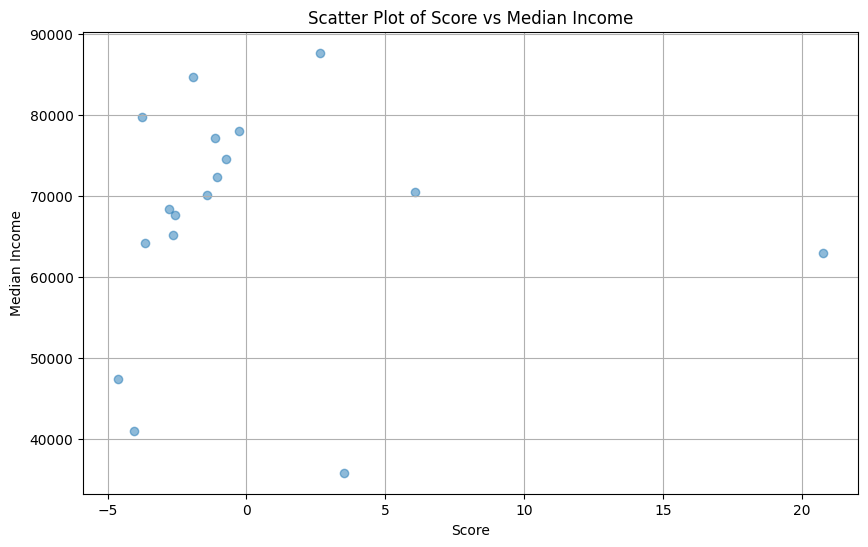

In [73]:
# Create a scatter plot of score vs median income
plt.figure(figsize=(10, 6))
plt.scatter(df['score'], df['median_income'], alpha=0.5)
plt.title('Scatter Plot of Score vs Median Income')
plt.xlabel('Score')
plt.ylabel('Median Income')
plt.grid(True)
plt.savefig("Plots/Scatter.png")
plt.show()

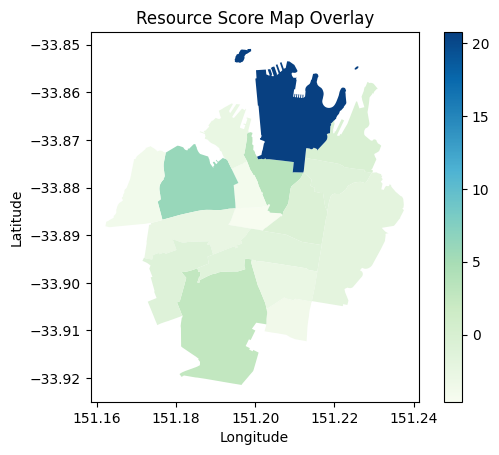

In [72]:
map_overlay = gpd.read_postgis("SELECT geom, score FROM SA2 s JOIN zscore r ON (s.sa2_code21 = r.sa2_code21)", conn, geom_col='geom')
plt.rcParams
map_overlay.plot(column='score', cmap='GnBu', legend=True)
plt.title('Resource Score Map Overlay')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('Plots/ResourceScoreMapOverlay.png')
plt.show()

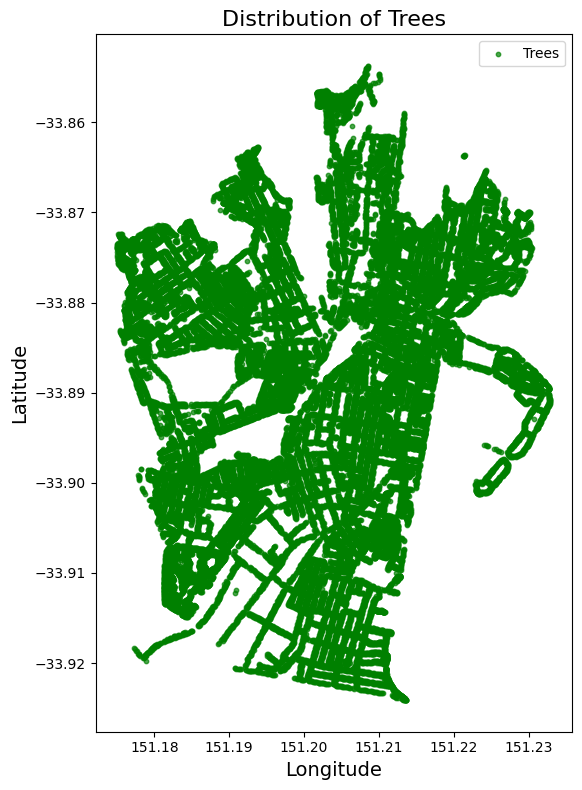

In [71]:
trees_df = gpd.read_postgis("SELECT * FROM trees", conn, geom_col='Geometry')
fig, ax = plt.subplots(figsize=(12, 8))
trees_df.plot(ax=ax, markersize=10, color='green', marker='o', alpha=0.7, label='Trees')
plt.title('Distribution of Trees', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('Plots/trees.png')
plt.show()

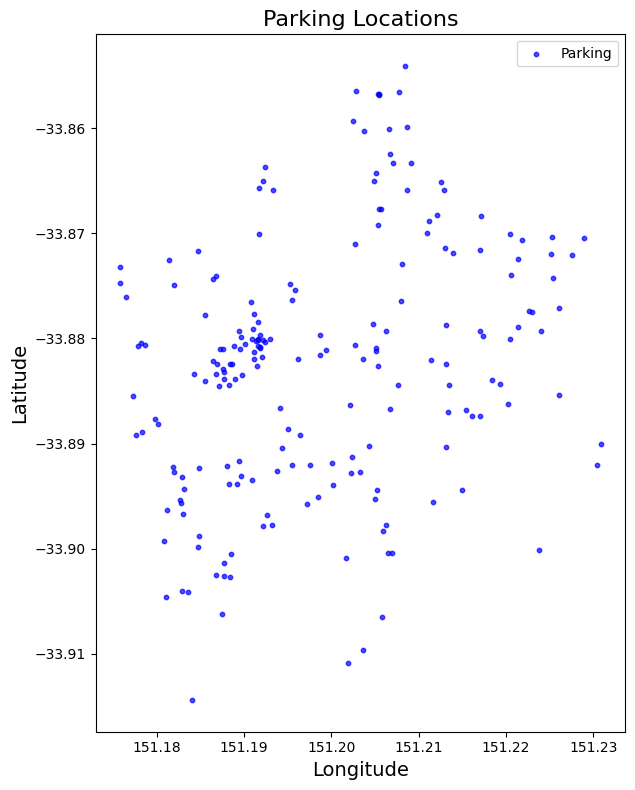

In [69]:
parking_df = gpd.read_postgis("SELECT * FROM parking", conn, geom_col='Geometry')
fig, ax = plt.subplots(figsize=(12, 8))
parking_df.plot(ax=ax, markersize=10, color='blue', marker='o', alpha=0.7, label='Parking')
plt.title('Parking Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('Plots/parking.png')
plt.show()

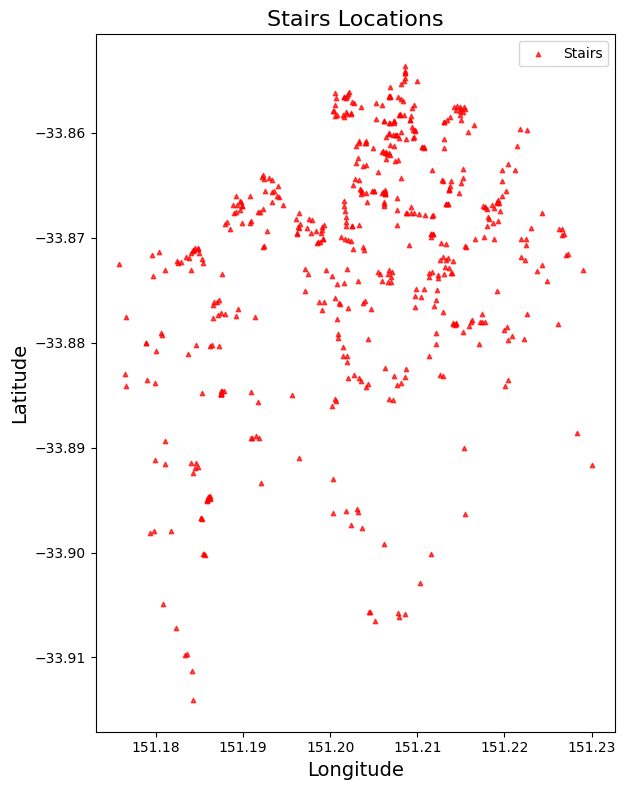

In [70]:
stairs_df = gpd.read_postgis("SELECT * FROM stairs", conn, geom_col='Geometry')
fig, ax = plt.subplots(figsize=(12, 8))
stairs_df.plot(ax=ax, markersize=10, color='red', marker='^', alpha=0.7, label='Stairs')
plt.title('Stairs Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('Plots/stairs.png')
plt.show()

## Data Description and Coorelation

In [68]:
print("Descriptive Statistics:")
print(combinedScore.describe())
print("\nMedian Income Statistics:")
print(Income.describe())

Descriptive Statistics:
         sa2_code21      score  bustling_score
count  1.700000e+01  17.000000       17.000000
mean   1.172651e+08   0.139311        0.338173
std    7.489093e+05   6.032882        0.383234
min    1.170313e+08  -4.614919        0.009806
25%    1.170313e+08  -2.775111        0.058684
50%    1.170316e+08  -1.435793        0.192198
75%    1.170316e+08  -0.287168        0.428697
max    1.200217e+08  20.765915        1.000000

Median Income Statistics:
         sa2_code21       earners  median_age  median_income    mean_income
count  6.420000e+02    642.000000  642.000000     642.000000     642.000000
mean   1.148262e+08   7169.939252   42.666667   55140.048287   70093.996885
std    8.158956e+06   3643.991978    6.638500   12034.997429   24369.047950
min    1.010210e+08      0.000000    0.000000       0.000000       0.000000
25%    1.080137e+08   4222.500000   40.000000   48504.250000   56426.750000
50%    1.160113e+08   7047.000000   43.000000   54625.500000   65187.0

In [60]:
# Merge the combined score DataFrame with the income DataFrame based on a common column 'sa2_code21'
correlation_df = pd.merge(combinedScore, Income, on='sa2_code21', how='inner')
# Calculate the correlation coefficient between the 'bustling_score' and 'median_income' columns in the merged DataFrame
correlation_coefficient = correlation_df['bustling_score'].corr(correlation_df['median_income'])
# Print the correlation coefficient between the 'bustling_score' and 'median_income'
print("Correlation coefficient between bustling_score and median income:", correlation_coefficient)

Correlation coefficient between bustling_score and median income: -0.010084457084966178
